In [195]:
import pandas as pd
import numpy as np
import random
from copy import copy, deepcopy
import torch
import torch.nn as nn
import math

from sktime.performance_metrics.forecasting import (mean_absolute_percentage_error,
                                                     mean_absolute_error)



import seaborn as sns

In [196]:
np.random.seed(0)

In [234]:
#creating the synthetic data
row_count = 1000
n_var = 20

if n_var<=10:
    step_val = 0.1/n_var
else:
    step_val = 0.05/n_var

start_var = np.round(np.random.rand(row_count)*10,0).tolist()
data_dct = {}

for x_var_num in range(n_var):
    data_dct[f'x{x_var_num}'] = []
data_dct[f'x{n_var-1}'] = start_var

all_cols = list(data_dct.keys())

multiply_factors = np.arange(start=1, stop=2, step=step_val)

# an implementation to produce cumulatively increasing array of values row wise
for row_num in range(row_count):
    factor_cpy = copy(multiply_factors)
    for index, x_var_num in enumerate(range(n_var-2,-1,-1)):
        # getting a window of factors as per the x_var_num
        windowed_factors = factor_cpy[index:index+3]
        last_used_factor = np.random.choice(a=windowed_factors,size=1)[0]

        calc_value = np.round(data_dct[f'x{x_var_num+1}'][row_num]*last_used_factor,2)
        
        data_dct[f'x{x_var_num}'].append(calc_value)

        factor_cpy = factor_cpy[factor_cpy>last_used_factor]

In [235]:
main_df = pd.DataFrame(data_dct)
main_df.head(3)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19
0,24.72,16.26,11.08,7.82,5.71,4.30,3.33,2.66,2.18,1.84,1.59,1.41,1.28,1.18,1.11,1.06,1.03,1.01,1.00,1.0
1,264.95,173.17,116.81,81.54,58.66,43.61,33.35,26.31,21.35,17.83,15.24,13.37,11.96,10.95,10.23,9.74,9.41,9.18,9.04,9.0
2,138.82,91.78,62.86,44.58,32.72,24.79,19.37,15.56,12.86,10.90,9.48,8.43,7.65,7.10,6.70,6.41,6.21,6.09,6.03,6.0


In [236]:
is_diff_data = True

if is_diff_data:
    main_df = pd.DataFrame(np.round(main_df[all_cols[:-1]].to_numpy()-main_df[all_cols[1:]].to_numpy(),3), columns=all_cols[:-1])
    n_var = len(main_df.columns)
    all_cols = list(main_df.columns)
    main_df.head()

In [237]:
def get_batch_indexes(batch_size, data_len, train_len):
    total_batches = train_len//batch_size

    batch_indexes = np.column_stack((np.arange(start=0,stop=data_len, step=batch_size),
               np.arange(start=0+batch_size,stop=data_len+batch_size, step=batch_size)))
    return batch_indexes[:total_batches]
    

In [238]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_emb, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_emb).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_emb, 2).float() * -(math.log(10000.0) / d_emb)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)[:pe[:, 0::2].shape[0],:pe[:, 0::2].shape[1]]
        pe[:, 1::2] = torch.cos(position * div_term)[:pe[:, 1::2].shape[0],:pe[:, 1::2].shape[1]]

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(2)]
    
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_emb):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_emb, 
                                    kernel_size=3, padding=1)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        # x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        x = self.tokenConv(x)
        return x
    

class Attention(nn.Module):
    def __init__(self, d_k,d_v,d_emb ) -> None:
        super(Attention, self).__init__()
        self.d_emb = d_emb
        self.W_query = nn.Parameter(torch.rand(d_k,d_emb))
        self.W_keys = nn.Parameter(torch.rand(d_k,d_emb))
        self.W_value = nn.Parameter(torch.rand(d_v,d_emb))

    def context_mat(self,query, keys):
        # scaled dot product of queries and keys
        Q_K = query.matmul(keys.permute(0,2,1))/np.sqrt(self.d_emb)
        # row-wise softmax
        sfmax_Q_K = torch.softmax(Q_K, dim=1)

        return sfmax_Q_K

    def forward(self,embed):

        query = embed.matmul(self.W_query.T) 
        keys = embed.matmul(self.W_keys.T)
        values = embed.matmul(self.W_value.T)
        
        sfmax_Q_K = self.context_mat(query=query, keys=keys)

        att_out = sfmax_Q_K.matmul(values).contiguous()

        return att_out, sfmax_Q_K
    

class AttentionForecastModel(nn.Module):
    def __init__(self, d_k,d_v,d_emb, batch_size, seq_len, out_seq_len, c_in=1) -> None:
        super(AttentionForecastModel, self).__init__()
        self.dim_emb = d_emb
        self.batch_size = batch_size
        self.seq_len=seq_len
        self.c_in = c_in
        self.out_seq_len = out_seq_len

        self.pos_emb = PositionalEmbedding(d_emb=d_emb)
        self.token_emb = TokenEmbedding(c_in=c_in, d_emb=d_emb)
        self.attention = Attention(d_emb=d_emb,d_k=d_k, d_v=d_v)
        self.linear_layer = nn.Linear(in_features=seq_len*d_v, out_features=out_seq_len)

        self.sfmax_Q_K = None

    def embed_output(self,input):
        input_tensor = torch.tensor(input.reshape((self.batch_size,self.c_in,self.seq_len)), 
                                    dtype=torch.float32)
        token_emb_out = self.token_emb(input_tensor)
        pos_emb_out = self.pos_emb(input_tensor)

        # changing dimensions while keeping the batch size dim the same
        embed_tensor = token_emb_out.permute(0,2,1)+pos_emb_out
        return embed_tensor


    def forward(self, input):
        embed_tensor = self.embed_output(input)
        attn_out, sfmax_Q_K=self.attention(embed_tensor)
        self.sfmax_Q_K = sfmax_Q_K
        final_output = self.linear_layer(attn_out.reshape((self.batch_size,-1)))

        return final_output
        

In [239]:
# batch_size = 10
# out_var = 2
# input_var = n_var - out_var
# input = main_df[sorted(all_cols, reverse=True)[:input_var]].iloc[:batch_size].to_numpy()
# Model = AttentionForecastModel(d_k=4, 
#                                d_v=3, 
#                                d_emb=5, 
#                                batch_size=batch_size,
#                                seq_len=input_var, 
#                                out_seq_len=out_var)
# Model(input)




In [240]:
EPOCHS = 50
OUT_VAR = 5
BATCH_SIZE = 10
feat_cols = all_cols[OUT_VAR:-1]
tgt_cols = all_cols[:OUT_VAR]

train_len = int(row_count*0.8)
batch_indexes = get_batch_indexes(batch_size=BATCH_SIZE, data_len=row_count, train_len=train_len)

Model = AttentionForecastModel(d_k=4, 
                               d_v=3, 
                               d_emb=5, 
                               batch_size=BATCH_SIZE,
                               seq_len=len(feat_cols), 
                               out_seq_len=len(tgt_cols))
optimizer = torch.optim.Adam(Model.parameters(), lr = 0.01)

for epoch in range(EPOCHS):
    epch_trn_cost = 0
    for st_index, end_index in batch_indexes:
        batch_data = main_df.iloc[st_index:end_index]
        feat_data = batch_data[feat_cols].to_numpy()
        tgt_data = torch.tensor(batch_data[tgt_cols].to_numpy(), dtype=torch.float32)

        pred_out = Model(feat_data)
        cost = nn.functional.huber_loss(pred_out,tgt_data)
        epch_trn_cost+=(float(cost.detach())/BATCH_SIZE)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    if epoch%10==0:
        print('train cost:',epch_trn_cost )


    

train cost: 33.43925895690917
train cost: 2.4557674184441556
train cost: 2.40232402123511
train cost: 2.3536803327500815
train cost: 2.3097049467265607


In [241]:
test_data = main_df.iloc[800:]

test_feat_data = test_data[feat_cols].to_numpy()
test_tgt_data = test_data[tgt_cols].to_numpy()

Model.batch_size= row_count-train_len
test_pred = Model(test_feat_data).detach().numpy()

test_pred_data = pd.DataFrame(np.round(test_pred,2))
test_pred_data.columns = [f'pred_x{i}' for i in range(OUT_VAR)]

In [242]:
combined_test_data =pd.concat([test_data.reset_index(drop=True),test_pred_data], axis=1)

In [243]:
mean_absolute_percentage_error(y_pred=combined_test_data['pred_x0'],
                               y_true=combined_test_data['x0'],
                               symmetric=True)

0.057130084748072595

In [244]:
combined_test_data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x14,x15,x16,x17,x18,pred_x0,pred_x1,pred_x2,pred_x3,pred_x4
0,29.84,18.37,11.52,7.49,4.99,3.40,2.35,1.66,1.18,0.84,...,0.18,0.12,0.07,0.03,0.01,29.900000,18.410000,11.530000,7.620000,5.23
1,25.46,15.66,9.85,6.43,4.27,2.91,2.02,1.41,1.00,0.72,...,0.13,0.08,0.05,0.03,0.01,25.520000,15.690000,9.830000,6.500000,4.45
2,68.24,41.76,26.39,17.12,11.31,7.70,5.31,3.79,2.72,2.00,...,0.36,0.23,0.12,0.06,0.02,68.209999,41.970001,26.360001,17.480000,12.00
3,8.87,5.43,3.44,2.24,1.50,1.01,0.70,0.49,0.35,0.26,...,0.05,0.04,0.02,0.01,0.00,9.250000,5.720000,3.590000,2.390000,1.65
4,74.88,45.93,28.96,18.83,12.41,8.48,5.87,4.14,2.94,2.11,...,0.39,0.27,0.18,0.08,0.04,74.820000,45.990002,28.830000,19.059999,13.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,81.22,49.64,31.06,20.06,13.28,9.05,6.21,4.38,3.11,2.26,...,0.45,0.29,0.18,0.10,0.02,80.300003,49.349998,30.900000,20.389999,13.98
196,50.49,31.01,19.56,12.54,8.29,5.58,3.89,2.76,1.96,1.41,...,0.25,0.17,0.10,0.04,0.01,48.880001,30.160000,18.969999,12.590000,8.67
197,20.41,12.43,7.75,4.97,3.28,2.20,1.51,1.06,0.75,0.55,...,0.11,0.07,0.05,0.02,0.00,19.299999,11.860000,7.450000,4.950000,3.39
198,9.13,5.60,3.52,2.29,1.51,1.03,0.71,0.50,0.36,0.26,...,0.05,0.04,0.02,0.01,0.00,9.350000,5.780000,3.630000,2.410000,1.67


In [245]:
test_attention_out = Model.sfmax_Q_K

In [246]:
test_attention_out[0].size()

torch.Size([13, 13])

In [247]:
len(feat_cols)

13

<Axes: >

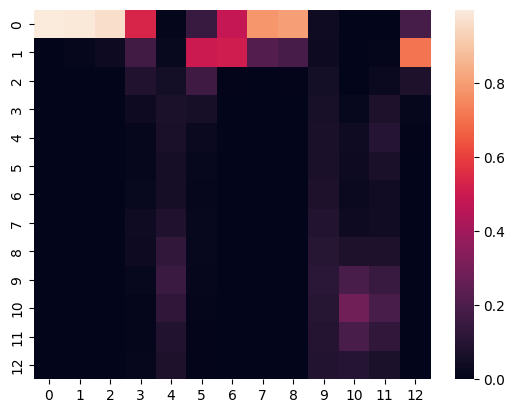

In [248]:
sns.heatmap(test_attention_out[5].detach().numpy())

In [249]:
# batch_size = 10
# input = main_df[all_cols].iloc[:batch_size].to_numpy().reshape((batch_size,1,7))

# tok_emb = TokenEmbedding(c_in=1, d_emb=5)
# output_tokn = tok_emb(torch.tensor(input, dtype=torch.float32))

# pos_emb = PositionalEmbedding(d_emb=5)

# output_pos = pos_emb(torch.tensor(input))

# output_emb = output_tokn.permute(0,2,1)+output_pos
